In [0]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [0]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# from google.colab import drive
# drive.mount ('/content/drive/')

In [0]:
quora = drive.CreateFile({'id':'10QDGTSI5PEV9e7CTpfzsXRpUwRIsJA-J'}) # replace the id with id of file you want to access
quora.GetContentFile('train.csv') 

**Importing the Library**

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from subprocess import check_output
%matplotlib inline
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import os
import gc

import re
from nltk.corpus import stopwords
# import distance
from nltk.stem import PorterStemmer
from bs4 import BeautifulSoup

**Reading data and basic stats**

In [13]:
data = pd.read_csv('train.csv')    # Read the dataset.
print(data.head(10))   # Print first 10 values.

   id  qid1  ...                                          question2 is_duplicate
0   0     1  ...  What is the step by step guide to invest in sh...            0
1   1     3  ...  What would happen if the Indian government sto...            0
2   2     5  ...  How can Internet speed be increased by hacking...            0
3   3     7  ...  Find the remainder when [math]23^{24}[/math] i...            0
4   4     9  ...            Which fish would survive in salt water?            0
5   5    11  ...  I'm a triple Capricorn (Sun, Moon and ascendan...            1
6   6    13  ...  What keeps childern active and far from phone ...            0
7   7    15  ...          What should I do to be a great geologist?            1
8   8    17  ...              When do you use "&" instead of "and"?            0
9   9    19  ...  How do I hack Motorola DCX3400 for free internet?            0

[10 rows x 6 columns]


In [14]:
data.tail()  # Print last 10 values.

id  ...  is_duplicate
404285  404285  ...             0
404286  404286  ...             1
404287  404287  ...             0
404288  404288  ...             0
404289  404289  ...             0

[5 rows x 6 columns]

In [15]:
data.shape

(404290, 6)

In [16]:
data.columns   # print coluns

Index(['id', 'qid1', 'qid2', 'question1', 'question2', 'is_duplicate'], dtype='object')

In [17]:
data.describe()   # Description of the dataset

id           qid1           qid2   is_duplicate
count  404290.000000  404290.000000  404290.000000  404290.000000
mean   202144.500000  217243.942418  220955.655337       0.369198
std    116708.614502  157751.700002  159903.182629       0.482588
min         0.000000       1.000000       2.000000       0.000000
25%    101072.250000   74437.500000   74727.000000       0.000000
50%    202144.500000  192182.000000  197052.000000       0.000000
75%    303216.750000  346573.500000  354692.500000       1.000000
max    404289.000000  537932.000000  537933.000000       1.000000

In [19]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404290 entries, 0 to 404289
Data columns (total 6 columns):
id              404290 non-null int64
qid1            404290 non-null int64
qid2            404290 non-null int64
question1       404289 non-null object
question2       404288 non-null object
is_duplicate    404290 non-null int64
dtypes: int64(4), object(2)
memory usage: 18.5+ MB


In [20]:
data.isnull().sum()

id              0
qid1            0
qid2            0
question1       1
question2       2
is_duplicate    0
dtype: int64

We are given a minimal number of data fields here, consisting of:

> id: Looks like a simple rowID

> qid{1, 2}: The unique ID of each question in the pair

> question{1, 2}: The actual textual contents of the questions.

> is_duplicate: The label that we are trying to predict - whether the two > questions are duplicates of each other.

**Distribution of data points among output classes**

Number of duplicate(smilar) and non-duplicate(non similar) questions

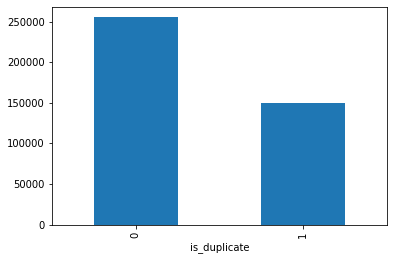

In [21]:
data.groupby('is_duplicate')['id'].count().plot.bar()

In [22]:
print('~> Total number of question pairs for training:\n   {}'.format(len(data)))

~> Total number of question pairs for training:
   404290


In [23]:
print('~> Question pairs are not Similar (is_duplicate = 0):\n   {}%'.format(100 - round(data['is_duplicate'].mean()*100, 2)))
print('\n~> Question pairs are Similar (is_duplicate = 1):\n   {}%'.format(round(data['is_duplicate'].mean()*100, 2)))

~> Question pairs are not Similar (is_duplicate = 0):
   63.08%

~> Question pairs are Similar (is_duplicate = 1):
   36.92%


**Number of unique questions**

In [27]:
qids = pd.Series(data['qid1'].tolist() + data['qid2'].tolist())
unique_qs = len(np.unique(qids))
qs_morethan_onetime = np.sum(qids.value_counts() > 1)
print ('Total number of  Unique Questions are: {}\n'.format(unique_qs))
#print len(np.unique(qids))

print ('Number of unique questions that appear more than one time: {} ({}%)\n'.format(qs_morethan_onetime,qs_morethan_onetime/unique_qs*100))

print ('Max number of times a single question is repeated: {}\n'.format(max(qids.value_counts()))) 

q_vals=qids.value_counts()

q_vals=q_vals.values

Total number of  Unique Questions are: 537933

Number of unique questions that appear more than one time: 111780 (20.77953945937505%)

Max number of times a single question is repeated: 157



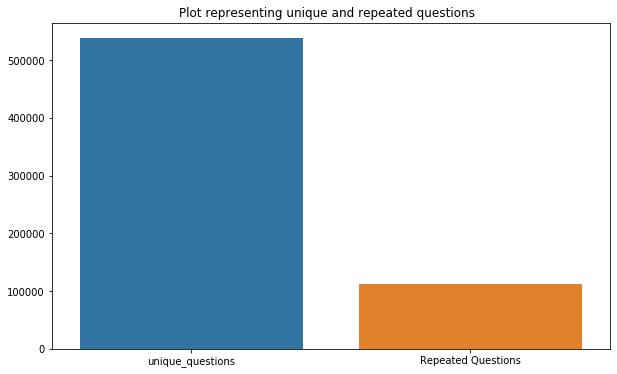

In [28]:
x = ["unique_questions" , "Repeated Questions"]
y =  [unique_qs , qs_morethan_onetime]

plt.figure(figsize=(10, 6))
plt.title ("Plot representing unique and repeated questions  ")
sns.barplot(x,y)
plt.show()

**Checking for Duplicates**

In [31]:
#checking whether there are any repeated pair of questions

pair_duplicates = data[['qid1','qid2','is_duplicate']].groupby(['qid1','qid2']).count().reset_index()

print ("Number of duplicate questions",(pair_duplicates).shape[0] - data.shape[0])

Number of duplicate questions 0


**Number of occurrences of each question**

Maximum number of times a single question is repeated: 157



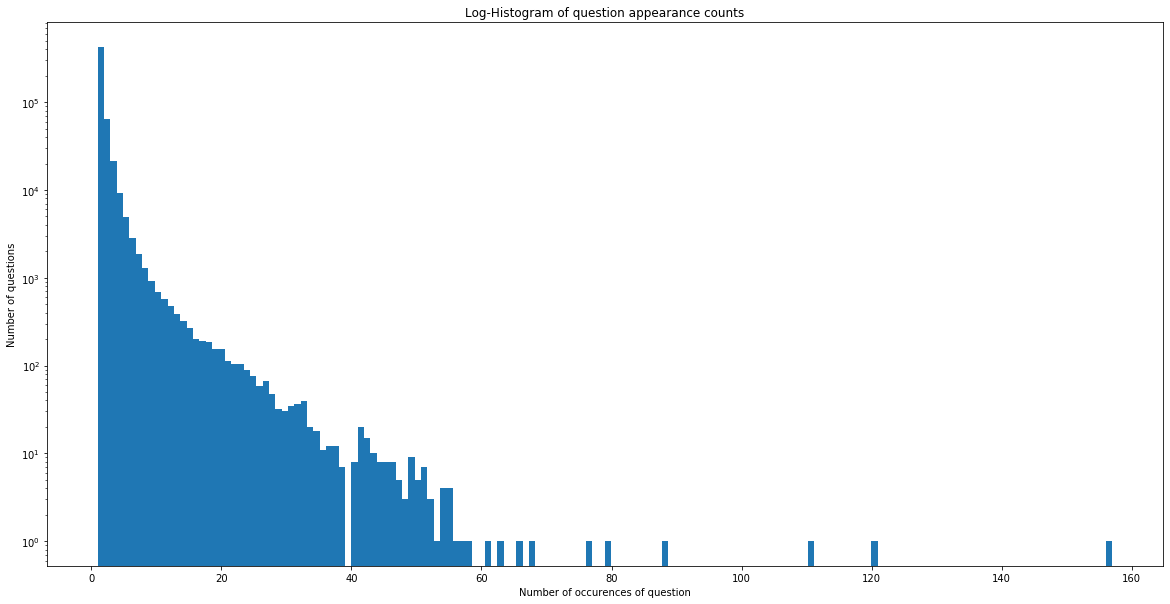

In [32]:
plt.figure(figsize=(20, 10))

plt.hist(qids.value_counts(), bins=160)

plt.yscale('log', nonposy='clip')

plt.title('Log-Histogram of question appearance counts')

plt.xlabel('Number of occurences of question')

plt.ylabel('Number of questions')

print ('Maximum number of times a single question is repeated: {}\n'.format(max(qids.value_counts())))

**Checking for NULL values**

In [33]:
#Checking whether there are any rows with null values
nan_rows = data[data.isnull().any(1)]
print (nan_rows)

            id  ...  is_duplicate
105780  105780  ...             0
201841  201841  ...             0
363362  363362  ...             0

[3 rows x 6 columns]


In [34]:
# Filling the null values with ' '
data = data.fillna('')
nan_rows = data[data.isnull().any(1)]
print (nan_rows)

Empty DataFrame
Columns: [id, qid1, qid2, question1, question2, is_duplicate]
Index: []


**Basic Feature Extraction (before cleaning)**

>Let us now construct a few features like:

>freq_qid1 = Frequency of qid1's

>freq_qid2 = Frequency of qid2's

>q1len = Length of q1

>q2len = Length of q2

>q1_n_words = Number of words in Question 1

>q2_n_words = Number of words in Question 2

>word_Common = (Number of common unique words in Question 1 and Question 2)

>word_Total =(Total num of words in Question 1 + Total num of words in Question 2)

>word_share = (word_common)/(word_Total)

>freq_q1+freq_q2 = sum total of frequency of qid1 and qid2

>freq_q1-freq_q2 = absolute difference of frequency of qid1 and qid2

In [0]:
quora = drive.CreateFile({'id':'1gTfCTD3fz-3NJnfYLm59nZFN3WC3fzfD'}) # replace the id with id of file you want to access
quora.GetContentFile('df_fe_without_preprocessing_train.csv') 

In [38]:
if os.path.isfile('df_fe_without_preprocessing_train.csv'):
    df = pd.read_csv("df_fe_without_preprocessing_train.csv",encoding='latin-1')
else:
    df['freq_qid1'] = df.groupby('qid1')['qid1'].transform('count') 
    df['freq_qid2'] = df.groupby('qid2')['qid2'].transform('count')
    df['q1len'] = df['question1'].str.len() 
    df['q2len'] = df['question2'].str.len()
    df['q1_n_words'] = df['question1'].apply(lambda row: len(row.split(" ")))
    df['q2_n_words'] = df['question2'].apply(lambda row: len(row.split(" ")))

    def normalized_word_Common(row):
        w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
        w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))    
        return 1.0 * len(w1 & w2)
    df['word_Common'] = df.apply(normalized_word_Common, axis=1)

    def normalized_word_Total(row):
        w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
        w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))    
        return 1.0 * (len(w1) + len(w2))
    df['word_Total'] = df.apply(normalized_word_Total, axis=1)

    def normalized_word_share(row):
        w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
        w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))    
        return 1.0 * len(w1 & w2)/(len(w1) + len(w2))
    df['word_share'] = df.apply(normalized_word_share, axis=1)

    df['freq_q1+q2'] = df['freq_qid1']+df['freq_qid2']
    df['freq_q1-q2'] = abs(df['freq_qid1']-df['freq_qid2'])

    df.to_csv("df_fe_without_preprocessing_train.csv", index=False)

df.head()

id  qid1  qid2  ... word_share freq_q1+q2  freq_q1-q2
0   0     1     2  ...   0.434783          2           0
1   1     3     4  ...   0.200000          5           3
2   2     5     6  ...   0.166667          2           0
3   3     7     8  ...   0.000000          2           0
4   4     9    10  ...   0.100000          4           2

[5 rows x 17 columns]

**Analysis of some of the extracted features**

In [39]:
print ("Minimum length of the questions in question1 : " , min(df['q1_n_words']))

print ("Minimum length of the questions in question2 : " , min(df['q2_n_words']))

print ("Number of Questions with minimum length [question1] :", df[df['q1_n_words']== 1].shape[0])
print ("Number of Questions with minimum length [question2] :", df[df['q2_n_words']== 1].shape[0])

Minimum length of the questions in question1 :  1
Minimum length of the questions in question2 :  1
Number of Questions with minimum length [question1] : 67
Number of Questions with minimum length [question2] : 24


**1.1 Feature: word_share**

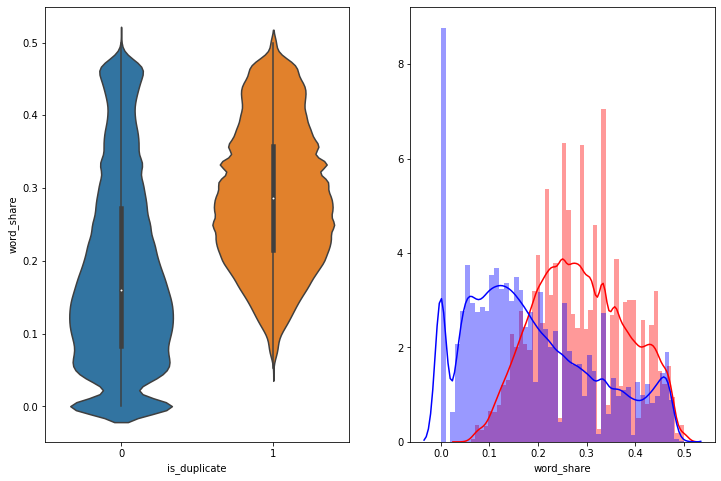

In [40]:
plt.figure(figsize=(12, 8))

plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'word_share', data = df[0:])

plt.subplot(1,2,2)
sns.distplot(df[df['is_duplicate'] == 1.0]['word_share'][0:] , label = "1", color = 'red')
sns.distplot(df[df['is_duplicate'] == 0.0]['word_share'][0:] , label = "0" , color = 'blue' )
plt.show()

The distributions for normalized word_share have some overlap on the far right-hand side, i.e., there are quite a lot of questions with high word similarity

The average word share and Common no. of words of qid1 and qid2 is more when they are duplicate(Similar)

**1.2 Feature: word_Common**

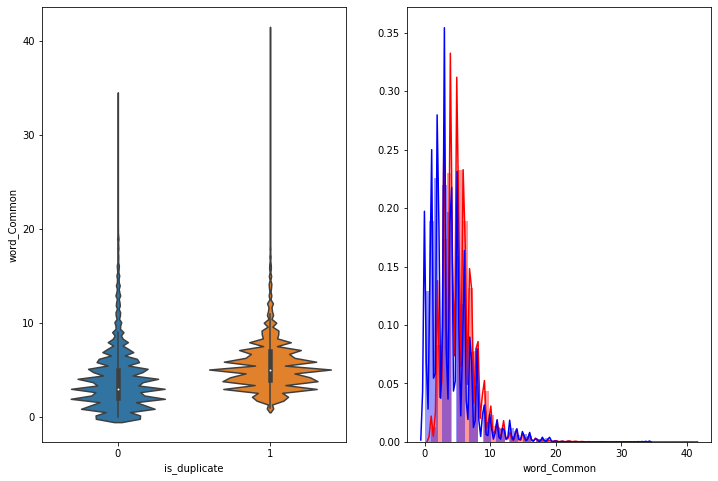

In [41]:
plt.figure(figsize=(12, 8))

plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'word_Common', data = df[0:])

plt.subplot(1,2,2)
sns.distplot(df[df['is_duplicate'] == 1.0]['word_Common'][0:] , label = "1", color = 'red')
sns.distplot(df[df['is_duplicate'] == 0.0]['word_Common'][0:] , label = "0" , color = 'blue' )
plt.show()